<a href="https://colab.research.google.com/github/wqiu96/summer_project/blob/master/src/Q_learning_dirichlet_2d_vGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import time
start_time = time.time()
from tqdm import tqdm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from numba import jitclass
from numba import int64, float64

__Goal__

Implement value iteration on 1d HJB with Dirichlet data and verify with the explicit solution on Whittle’s “Flypaper”

__Ref__

- [1] Chap V.7 of [Roger and Williams 2000] 

- [2] P97, Example 4 of [Kushner and Dupuis 2001]

- [previous version](https://github.com/songqsh/foo1/blob/master/src/value_iter_dirichlet_1d.ipynb)


__Problem setup__

We want to solve a d-dimensions HJB
$$\inf_a \{\sum_{i=1}^db_i(x,a)  \frac{\partial v(x)}{\partial x_i}  + \frac 1 2 \sum_{i,j=1}^{d} \hat \sigma_{ij} \frac{\partial^2 v(x)}{\partial x_i \partial x_j} - \lambda v(x) + \ell(x,a)\} = 0, \quad \hbox{ where } \hat \sigma _{ij} = \sigma*\sigma^T , \sum_{i=1}^{d}x_i^2\leq1$$
with Dirichlet data
$$v(x_1,x_2,..,x_d) = g(x_1,x_2,..,x_d), \quad \hbox{ when } \sum_{i=1}^{d}x_i^2 = 1$$




__MDP discretization__

Approximation:
$$
\frac{\partial v(x)}{\partial x_i} \leftarrow \frac{v(x+e_ih)-v(x-e_ih)}{2h}
$$
when $i = j$
$$
\frac{\partial^2 v(x)}{\partial x_i^2} \leftarrow \frac{v(x+e_ih)-2v(x)+v(x-e_ih)}{h^2}
$$
when $i \neq j$
$$
\frac{\partial^2 v(x)}{\partial x_i^2} \leftarrow \frac{v(x+e_ih+e_jh)-v(x+e_ih-e_jh)-v(x-e_ih+e_jh)+v(x-e_ih-e_jh)}{4h^2}
$$
then
$$\inf_a \{v(x)(-\lambda-\sum_{i=1}^{d}\frac{\hat \sigma_{ii}}{h^2})+\sum_{i=1}^{d}v(x+e_ih)\frac{b_i(x,a)h+\sigma_{ii}}{2h^2}+\sum_{i=1}^{d}v(x-e_ih)\frac{-b_i(x,a)h+\sigma_{ii}}{2h^2}+    \\
\sum_{i,j=1,i\neq j}^{d}(v(x+e_ih+e_jh)-v(x+e_ih-e_jh)-v(x-e_ih+e_jh)+v(x-e_ih-e_jh))\frac{\hat \sigma_{ij}}{8h^2}+ \ell(x,a)\} = 0
$$
Set
$$
c_1 = \lambda+\sum_{i=1}^{d}\frac{\hat \sigma_{ii}}{h^2}
$$
$$
\Lambda = \frac{\sum_{i=1}^{d}\frac{\lambda h^2+\sigma_{ii}}{h^2}}{\sum_{i=1}^{d}\frac{\sigma_{ii}}{h^2}}=\frac{\lambda h^2+\sum_{i=1}^{d}{\sigma_{ii}}}{\sum_{i=1}^{d}\sigma_{ii}}
$$
Then
$$
p^h(x+e_ih|x_i, a_i) = \Lambda \cdot (\frac{b_i(x,a)h + \hat \sigma_{ii}}{2c_1h^2})
$$
$$
p^h(x-e_ih|x_i, a_i) = \Lambda \cdot (\frac{-b_i(x,a)h + \hat \sigma_{ii}}{2c_1h^2})
$$
$$
p^h(x \pm e_ih \pm e_jh|x_i, x_j) = \Lambda \cdot \frac{\hat \sigma_{ij}}{8h^2}
$$
$$
 \hat \ell(x,a)=\frac{\ell(x,a)}{c_1}
$$
so 

$$
v(x) = \inf_a\{\sum_{i=1}^{d}p^h(x+e_ih|x_i, a_i)v(x+e_ih) +\sum_{i=1}^{d}p^h(x-e_ih|x_i, a_i)v(x-e_ih) \\
+ \sum_{i,j=1,i\neq j}^{d}(v(x+e_ih+e_jh)-v(x+e_ih-e_jh)-v(x-e_ih+e_jh)+v(x-e_ih-e_jh))p^h(x \pm e_ih \pm e_jh|x_i, x_j) + \hat \ell(x,a) \}
$$

__Example__
$$
\inf_a(a \bigtriangledown v + \frac 1 2 \bigtriangleup v +d + 2|x|^2 + \frac 1 2 |a| ^2)
$$

where
$$
v(x) = g(x) = -|x|^2 = -(x_1^2 + x_2^2 +...+x_d^2)\\
$$
In this case
$$
b(x,a) = (a_1, a_2,...,a_d) \\
\begin{equation*}
\hat \sigma =\begin{bmatrix}
1 & 0&\dots & 0\\
0 &1 &\dots &0\\
0 & 0 &\dots & 1
\end{bmatrix}_{d\times d}
\end{equation*}
$$
$$
\ell(x,a) = d + 2|x|^2 + \frac 1 2 |a|^2
$$
the exact solution is 
$$
v(x) =  -|x|^2 = -(x_1^2 + x_2^2 +...+x_d^2)
$$

__Rk__

There is essential difference of above MDP approximation using central FDM from the one
using upward FDM provided by P97 of [2].

In [0]:
#PDE to be solved
spec = [
    ('dim', int64),               # a simple scalar field
    ('NUM', int64),
    ('x_space',float64[:]),    # an array field
    ('a_space',float64[:]),
    ('sigma',float64[:,:]),
    ('s_val',float64[:,:]),
    ('q_table',float64[:,:,:,:]),
    ('LIM', int64),
    ('lambda_',float64),
    ('h',float64)
]
@jitclass(spec)
class pde:
  def __init__(self,dim,NUM):
    #pde config
    
    self.dim = dim
    
    self.NUM = NUM
    
    self.LIM = 1 #limit for state
    
    self.h = 1./self.NUM #mesh size in state space

    self.lambda_ = 0. #discount rate
    
    self.sigma = np.eye(self.dim) #diffusion coefficient matrix
 
    self.x_space = np.array([i*self.h for i in range(-self.NUM*self.LIM, (self.NUM+1)*self.LIM)])
  
    self.a_space = np.array([i*self.h for i in range(-self.NUM*self.LIM, (self.NUM+1)*self.LIM)])
    
    self.s_val = np.zeros((2*NUM+1,2*NUM+1))
    
    self.q_table = np.zeros((2*NUM+1,2*NUM+1,2*NUM+1,2*NUM+1))
    
  def drift(self,x,a):
    return a

  def run_cost(self,x,a):
    return self.dim + 2*np.sum(np.power(x,2)) + (1/2)*np.sum(np.power(a,2))

  def term_cost(self,x):
    return -np.sum(np.power(x,2))
  
  def diagonal(self,sigma):      # array.diagonal() can not be used in jitclass
    res = np.zeros(sigma.shape[0])
    for i in range(sigma.shape[0]):
      res[i] = sigma[i,i]
    return res
  
  def mdp_space_config(self):

      #s_val and q-table terminal setup
    for i in range(self.s_val.size):  # visit all x States
      k = 0
      x_d = np.zeros(self.dim)          
      s_index = np.zeros(self.dim, dtype = np.int64)
      Limit = 0
      while k < self.dim:
        x_d[k] = self.x_space[(i//(self.x_space.size**k))%self.x_space.size]
        s_index[k] = (i//(self.x_space.size**k))%self.x_space.size
        Limit += self.x_space[(i//(self.x_space.size**k))%self.x_space.size]**2
        k += 1
      if (np.min(s_index) == 0) or (np.max(s_index) == (self.x_space.size - 1)): # visit the terminal condition 
        self.s_val[s_index[0],s_index[1]] = self.term_cost(x_d)
        for j in range(self.a_space.size**self.dim):
          m = 0
          a_index = np.zeros(self.dim, dtype = np.int64)
          while m < self.dim:
            a_index[m] = (i//(self.a_space.size**m))%self.a_space.size
            m += 1
          self.q_table[s_index[0],s_index[1],a_index[0],a_index[1]] = self.term_cost(x_d)
    return self.q_table
  

  def mdp_trans_prob_central(self,x,a,sigma):
    tp_right = np.zeros((self.dim,self.dim))
    tp_left = np.zeros((self.dim,self.dim))
    b_ = self.drift(x,a)

    c1 = self.lambda_ + np.sum(self.diagonal(self.sigma))/(self.h**2)
    Lambda = 1 + self.lambda_*(self.h**2)/np.sum(self.diagonal(self.sigma))

    tp_right =Lambda*sigma/(8*c1*self.h**2)
    tp_left = Lambda*sigma/(8*c1*self.h**2)

    p_right = Lambda*((b_*self.h + self.diagonal(self.sigma))/(2*c1*self.h**2))
    p_left = Lambda*((-1*b_*self.h + self.diagonal(self.sigma))/(2*c1*self.h**2))
    for i in range(self.dim):
      tp_right[i,i] = p_right[i]
      tp_left[i,i] = p_left[i]

    discount = 1+2*np.sum(Lambda*sigma/(8*c1*self.h**2)) - 2*np.sum(self.diagonal((Lambda*sigma/(8*c1*self.h**2))))
    tp_right = tp_right/(discount - np.sum(p_left))
    tp_left = tp_left/(discount - np.sum(p_right))


    return tp_right, tp_left

  def q_learning(self, 
                 n_epoch = 500000, #tolerance for iteration
                 learning_rate = 0.01, #maximum iteration
                ):
    q_table = self.q_table.copy() # Numba doesn’t seem to care when I modify a global variable
    s_val = self.s_val.copy()  # Numba doesn’t seem to care when I modify a global variable
    start_ind = np.array([self.NUM+1,self.NUM+1])
    Lambda_ = 1 + self.lambda_*(self.h**2)/np.sum(self.diagonal(self.sigma))# reciprocal of discount factor
    
    for epoch in range(n_epoch):
      now_ind_ = start_ind.copy() #start
      
      while (np.min(now_ind_) != 0 and np.max(now_ind_) != (self.x_space.size - 1)):
        if np.random.random() > 0.05:
          res = np.where(q_table[now_ind_[0],now_ind_[1]] == np.min(q_table[now_ind_[0],now_ind_[1]])) #choose action index
          act_ind_ = np.array([res[i][0] for i in range(len(res))])

        else:
          act_ind_ = np.array([np.random.randint(self.a_space.size),np.random.randint(self.a_space.size)])
         
        x_ = np.array([self.x_space[now_ind_[0]],self.x_space[now_ind_[1]]]) #current state
        a_ = np.array([self.a_space[act_ind_[0]],self.a_space[act_ind_[1]]]) #current action
        c1 = self.lambda_ + np.sum(self.diagonal(self.sigma))/(self.h**2)
        run_cost_ = (self.run_cost(x_,a_))/c1

        tp_right, tp_left = self.mdp_trans_prob_central(x_, a_, self.sigma)
        sampling_ = np.random.binomial(1, 0.5)
        index_ = np.arange(self.dim**2)
        
        temp = 0
        next_ind_ = now_ind_.copy()

        if sampling_ == 0:
  
          temp = index_[np.searchsorted(np.cumsum(tp_right.reshape(self.dim**2)), np.random.rand(1))[0]]  #numpy.random.choice(): the optional p argument (probabilities array) is not supported

          if temp//self.dim != temp%self.dim:

            next_ind_[temp//self.dim] = now_ind_[temp//self.dim] + 1
            next_ind_[temp%self.dim] = now_ind_[temp%self.dim] + 1

          else:
            next_ind_[temp//self.dim] = now_ind_[temp//self.dim] + 1
        else:

          temp = index_[np.searchsorted(np.cumsum(tp_left.reshape(self.dim**2)), np.random.rand(1))[0]]

          if temp//self.dim != temp%self.dim:

            next_ind_[temp//self.dim] = now_ind_[temp//self.dim] - 1
            next_ind_[temp%self.dim] = now_ind_[temp%self.dim] - 1

          else:
            next_ind_[temp//self.dim] = now_ind_[temp//self.dim] - 1 
        old = q_table[now_ind_[0],now_ind_[1]].copy()
        del_q = run_cost_ + s_val[next_ind_[0],next_ind_[1]]/Lambda_ - old[act_ind_[0],act_ind_[1]]
        q_table[now_ind_[0],now_ind_[1],act_ind_[0],act_ind_[1]] = old[act_ind_[0],act_ind_[1]] + learning_rate*del_q
        s_val[now_ind_[0],now_ind_[1]] = np.min(q_table[now_ind_[0],now_ind_[1]]) #sync q_table with s_val
        now_ind_ = next_ind_.copy()
    return s_val
    

In [0]:
pde1 = pde(dim=2,NUM=10)
q_table = pde1.mdp_space_config()
Z1 = pde1.q_learning(50000,0.01)

In [34]:
end_time = time.time()
print('elapsed time is %f seconds' %(end_time - start_time))

elapsed time is 35.013495 seconds


>>>max norm of error is 0.44275339075411985
>>>Percentage of error is 0.24195240744041302


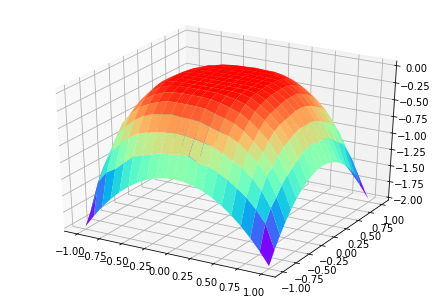

In [35]:
figure = plt.figure()
axes = Axes3D(figure)
X1 = pde1.x_space
X2 = pde1.x_space
X1, X2 = np.meshgrid(X1, X2)
Z = -(X1)**2 - (X2)**2
axes.plot_surface(X1, X2, Z1,cmap='rainbow')
print('>>>max norm of error is ' + str(np.max(np.abs(Z-Z1))))
print('>>>Percentage of error is ' + str(np.sum(np.abs(Z-Z1))/np.sum(np.abs(Z))))